<a href="https://colab.research.google.com/github/leti-olabarri/drunk-chatbot/blob/develop/models/Classification_with_more_features.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [68]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Concatenate
from tensorflow.keras.utils import plot_model

import pandas as pd
import matplotlib.pyplot as plt
import re
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
!wget /resources/data/all.txt https://drive.google.com/file/d/1IH1tCQRbJBJGTnUxKNnCwvhLI9IPVCnf/view?usp=sharing

/resources/data/all.txt: Scheme missing.
--2021-10-24 09:04:30--  https://drive.google.com/file/d/1IH1tCQRbJBJGTnUxKNnCwvhLI9IPVCnf/view?usp=sharing
Resolving drive.google.com (drive.google.com)... 142.250.141.100, 142.250.141.138, 142.250.141.101, ...
Connecting to drive.google.com (drive.google.com)|142.250.141.100|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘view?usp=sharing’

view?usp=sharing        [ <=>                ]  65.16K  --.-KB/s    in 0.03s   

2021-10-24 09:04:31 (2.33 MB/s) - ‘view?usp=sharing’ saved [66726]

FINISHED --2021-10-24 09:04:31--
Total wall clock time: 0.5s
Downloaded: 1 files, 65K in 0.03s (2.33 MB/s)


In [3]:
def starts_with_date_and_time(string):
    pattern = '^([0-9]+)(/)([0-9]+)(/)([0-9][0-9]) ([0-9]+):([0-9][0-9]) -'
    result = re.match(pattern, string)
    if result:
        return True
    return False

def get_data_point(line):   
    splitLine = line.split(' - ')
    dateTime = splitLine[0]
    date, time = dateTime.split(' ') 
    message = ' '.join(splitLine[1:])
    splitMessage = message.split(': ')
    author = splitMessage[0]
    message = ' '.join(splitMessage[1:])
    return date, time, author, message

parsedData = [] # List to keep track of data so it can be used by a Pandas dataframe
### Uploading exported chat file
conversationPath = '../content/drive/MyDrive/data/all.txt' # chat file
with open(conversationPath, encoding="utf-8") as fp:
    ### Skipping first line of the file because contains information related to something about end-to-end encryption
    fp.readline() 
    messageBuffer = [] 
    date, time, author = None, None, None
    while True:
        line = fp.readline() 
        if not line: 
            break
        line = line.strip()
        if starts_with_date_and_time(line):
            if len(messageBuffer) > 0: 
                parsedData.append([date, time, author, ' '.join(messageBuffer)]) 
            messageBuffer.clear()
            date, time, author, message = get_data_point(line) 
            messageBuffer.append(message)
        else:
            messageBuffer.append(line)
df = pd.DataFrame(parsedData, columns=['Date', 'Time', 'Author', 'Message']) # Initialising a pandas Dataframe.
### changing datatype of "Date" column.
df["Date"] = pd.to_datetime(df["Date"])
df["Time"] = pd.to_datetime(df["Time"], format='%H%M', errors='ignore')

In [4]:
df.head()

,Date,Time,Author,Message
0,2019-12-20,21:17,Leticia Olábarri,Adri
1,2019-12-20,21:17,Leticia Olábarri,¿Vienes?
2,2019-12-20,22:02,Adri Ávalos,Sí 😬
3,2019-12-20,22:03,Adri Ávalos,Ya voy
4,2019-12-20,22:03,Adri Ávalos,Me he liado un pelin


In [5]:
df.drop(df[(df['Author'] == 'Los mensajes y las llamadas están cifrados de extremo a extremo. Nadie fuera de este chat, ni siquiera WhatsApp, puede leerlos ni escucharlos. Toca para obtener más información.')].index, inplace=True)
df.drop(df[(df['Author'] == '\u200eMarcela Duque cambió su número de teléfono. Toca para enviar un mensaje o añadir el nuevo número.')].index, inplace=True)
df.drop(df[(df['Author'] == '\u200eMarcela Duque cambió su número de teléfono. Actualmente te estás comunicando con su nuevo número. Toca para añadir a tus contactos.')].index, inplace=True)

In [6]:
df.drop(df[(df['Message'] == '<Multimedia omitido>')].index, inplace=True)

In [7]:
df["Message total length"] = df["Message"].apply(lambda x: len(x))
df.drop(df[(df['Message total length'] < 10)].index, inplace=True)

In [8]:
def count_words(string):
    word_list = string.split()

    number_of_words = len(word_list)
    return number_of_words

df["Number of words"] = df["Message"].apply(lambda x: count_words(x))

In [9]:
def count_intro_signs(string):
    count = 0
    for i in string:
        if (i == "¿") or (i == "¡"):
            count = count + 1
    return count

df["Number of intro signs (¿ or ¡)"] = df["Message"].apply(lambda x: count_intro_signs(x))

In [10]:
def count_stops_and_commas(string):
    count = 0
    for i in string:
        if (i == ".") or (i == ","):
            count = count + 1
    return count

df["Number of stops and commas"] = df["Message"].apply(lambda x: count_stops_and_commas(x))

In [11]:
def count_strange_words(string):
    count = 0
    word_list = string.split()
    if (" xfa " in word_list) or (" q " in word_list):
        count = count + 1
    return count

df["Number of attypical abbreviations"] = df["Message"].apply(lambda x: count_strange_words(x))

In [12]:
df.head()

,Date,Time,Author,Message,Message total length,Number of words,Number of intro signs (¿ or ¡),Number of stops and commas,Number of attypical abbreviations
4,2019-12-20,22:03,Adri Ávalos,Me he liado un pelin,20,5,0,0,0
5,2019-12-20,22:09,Leticia Olábarri,Vaaaaaamooooooossssss,21,1,0,0,0
7,2019-12-20,22:14,Leticia Olábarri,Avisa cuando llegues,20,3,0,0,0
9,2019-12-20,22:15,Adri Ávalos,Por dónde estáis ?,18,4,0,0,0
11,2019-12-20,22:15,Leticia Olábarri,Enfrente del escenario,22,3,0,0,0


In [13]:
df.shape

(43096, 9)

In [14]:
def transform_names(name):
    if name == "Leticia Olábarri":
        return 1
    else:
        return 0

df["Author"] = df["Author"].apply(transform_names)

In [15]:
df.head()

,Date,Time,Author,Message,Message total length,Number of words,Number of intro signs (¿ or ¡),Number of stops and commas,Number of attypical abbreviations
4,2019-12-20,22:03,0,Me he liado un pelin,20,5,0,0,0
5,2019-12-20,22:09,1,Vaaaaaamooooooossssss,21,1,0,0,0
7,2019-12-20,22:14,1,Avisa cuando llegues,20,3,0,0,0
9,2019-12-20,22:15,0,Por dónde estáis ?,18,4,0,0,0
11,2019-12-20,22:15,1,Enfrente del escenario,22,3,0,0,0


In [16]:
X = df.drop(columns=["Author", "Date", "Time"])

In [17]:
X.head()

,Message,Message total length,Number of words,Number of intro signs (¿ or ¡),Number of stops and commas,Number of attypical abbreviations
4,Me he liado un pelin,20,5,0,0,0
5,Vaaaaaamooooooossssss,21,1,0,0,0
7,Avisa cuando llegues,20,3,0,0,0
9,Por dónde estáis ?,18,4,0,0,0
11,Enfrente del escenario,22,3,0,0,0


In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, df["Author"], test_size=0.2, random_state=42)

In [20]:
X_train.shape

(34476, 6)

In [21]:
X_test.shape

(8620, 6)

In [22]:
y_train.shape

(34476,)

In [23]:
y_test.shape

(8620,)

In [24]:
y_test.head()

13330    1
23560    1
22477    1
45727    1
52977    0
Name: Author, dtype: int64

In [26]:
labels = y_train.unique()
labels

array([1, 0])

In [170]:
input_1 = Input(shape=(None, None, 1000), name="message")
input_2 = Input(shape=(None, None, 1), name="length")
input_3 = Input(shape=(None, None, 1), name="word_count")
input_4 = Input(shape=(None, None, 1), name="intro_signs")
input_5 = Input(shape=(None, None, 1), name="punctuation")
input_6 = Input(shape=(None, None, 1), name="abbreviatures")

conc = Concatenate()([input_1, input_2, input_3, input_4, input_5, input_6])

hidden = Dense(100)(conc)

output_1 = Dense(1)(hidden)

<KerasTensor: shape=(None, None, 1005) dtype=float32 (created by layer 'concatenate_16')>

In [144]:
model = Model(inputs=[input_1, input_2, input_3, input_4, input_5, input_6],outputs=[output_1])

In [140]:
model.summary()

Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
message (InputLayer)            [(None, None, 1000)] 0                                            
__________________________________________________________________________________________________
length (InputLayer)             [(None, None, 1)]    0                                            
__________________________________________________________________________________________________
word_count (InputLayer)         [(None, None, 1)]    0                                            
__________________________________________________________________________________________________
intro_signs (InputLayer)        [(None, None, 1)]    0                                            
___________________________________________________________________________________________

In [146]:
model.compile(loss="mse")

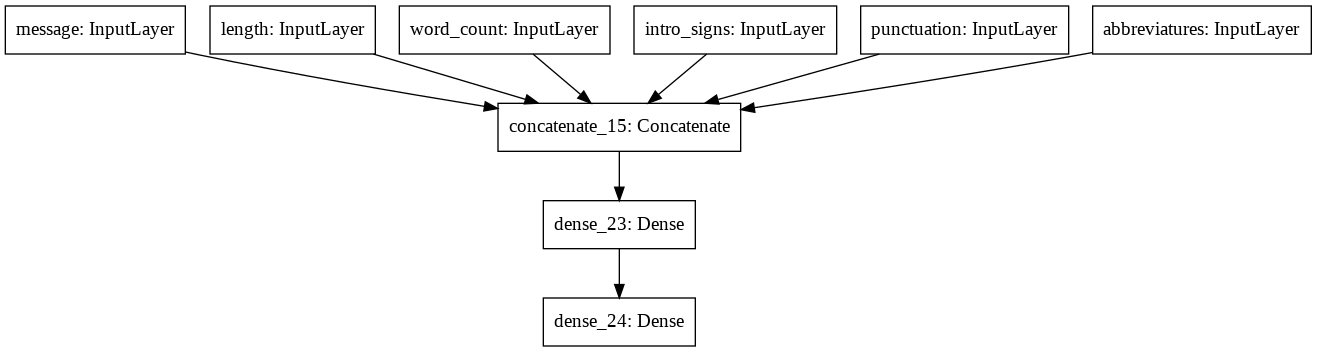

In [122]:
plot_model(model)

In [123]:
X_train_mess = X_train["Message"]
X_test_mess = X_test["Message"]
X_train_length = X_train["Message total length"]
X_test_length = X_test["Message total length"]
X_train_words = X_train["Number of words"]
X_test_words = X_test["Number of words"]
X_train_intro = X_train["Number of intro signs (¿ or ¡)"]
X_test_intro = X_test["Number of intro signs (¿ or ¡)"]
X_train_punctuation = X_train["Number of stops and commas"]
X_test_punctuation = X_test["Number of stops and commas"]
X_train_abbrev = X_train["Number of attypical abbreviations"]
X_test_abbrev = X_test["Number of attypical abbreviations"]


In [124]:
max_features = 10000
sequence_length = 1000

vectorize_layer = layers.TextVectorization(
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

In [125]:
vectorize_layer.adapt(X_train_mess)


In [151]:
train_ds_mess = vectorize_layer(X_train_mess)
test_ds_mess = vectorize_layer(X_test_mess)
print(train_ds_mess)

tf.Tensor(
[[  18   10    3 ...    0    0    0]
 [  14   13   46 ...    0    0    0]
 [9522  117  107 ...    0    0    0]
 ...
 [2414 8310    0 ...    0    0    0]
 [1319   37    0 ...    0    0    0]
 [  28    1   10 ...    0    0    0]], shape=(34476, 1000), dtype=int64)


In [147]:
model.fit(
    x=[train_ds_mess, X_train_length, X_train_words, X_train_intro, X_train_punctuation, X_train_abbrev], y=y_train, batch_size=None, epochs=10, verbose='auto',
    callbacks=None, validation_split=0.0, validation_data=([test_ds_mess, X_test_length, X_test_words, X_test_intro, X_test_punctuation, X_test_abbrev], y_test),
    class_weight=None, sample_weight=None, initial_epoch=0, steps_per_epoch=None,
    max_queue_size=10, workers=1
)

Epoch 1/10
1078/1078 [==============================] - 5s 4ms/step - loss: 8703.4941 - val_loss: 3292.2957
Epoch 2/10
1078/1078 [==============================] - 4s 4ms/step - loss: 3742.4453 - val_loss: 634.5852
Epoch 3/10
1078/1078 [==============================] - 4s 4ms/step - loss: 672.5385 - val_loss: 44.0401
Epoch 4/10
1078/1078 [==============================] - 4s 4ms/step - loss: 63.3477 - val_loss: 10.2529
Epoch 5/10
1078/1078 [==============================] - 4s 4ms/step - loss: 16.8843 - val_loss: 5.8276
Epoch 6/10
1078/1078 [==============================] - 4s 4ms/step - loss: 11.3192 - val_loss: 7.8046
Epoch 7/10
1078/1078 [==============================] - 4s 4ms/step - loss: 14.4732 - val_loss: 9.9024
Epoch 8/10
1078/1078 [==============================] - 4s 4ms/step - loss: 9.8987 - val_loss: 4.6878
Epoch 9/10
1078/1078 [==============================] - 4s 4ms/step - loss: 12.7695 - val_loss: 5.5683
Epoch 10/10
1078/1078 [==============================] - 4s 4m

In [167]:
message = "Ola k ase tronco te vaaaass ya?"
length = len(message)
word_count = count_words(message)
intro_signs = count_intro_signs(message)
punctuation = count_stops_and_commas(message)
abbrev = count_strange_words(message)

message = vectorize_layer(message)

In [168]:
model([[message], [length], [word_count], [intro_signs], [punctuation], [abbrev]]
      )

InvalidArgumentError: ignored